In [1]:
! pip install kaggle --upgrade
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}

! conda install -y -c haasad eidl7zip
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! 7za -bd -y x {path}/test-jpg-additional.tar.7z -o{path}
! tar -xf {path}/test-jpg-additional.tar -C {path}
! unzip -q -n {path}/train_v2.csv.zip -d {path}
! rsync -aP {path}/test-jpg-additional/ {path}/test-jpg/

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
path = '/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/planet'
path

'/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/planet'

In [5]:
df = pd.read_csv(path + '/train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
np.random.seed(42)

src = (ImageFileList.from_folder(path)            
       .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')  
       .random_split_by_pct(0.2))

data = (src.datasets()
        .transform(tfms, size=256)
        .databunch(bs=32).normalize(imagenet_stats))

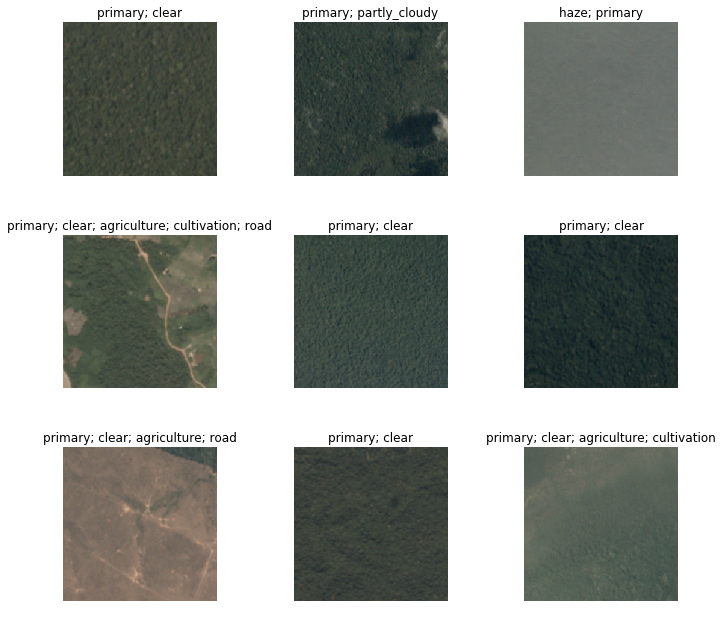

In [8]:
data.show_batch(rows=3, figsize=(10,9))

In [9]:
arch = models.resnet50

In [10]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [11]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


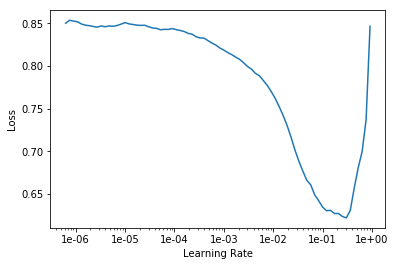

In [12]:
learn.recorder.plot()

In [13]:
lr = 0.01

In [14]:
learn.fit_one_cycle(5, slice(lr))

Total time: 32:58
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.120379    0.106511    0.947557         0.902783  (06:37)
2      0.108676    0.102418    0.954722         0.908341  (06:35)
3      0.106016    0.090481    0.954947         0.923472  (06:35)
4      0.093778    0.085595    0.957556         0.927278  (06:35)
5      0.093566    0.084242    0.959925         0.927568  (06:35)



In [17]:
learn.save('stage-1-rn50')

In [18]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


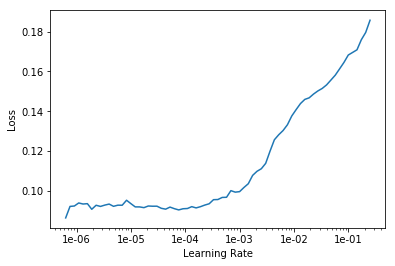

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, slice(1e-6, 1e-5))

Total time: 43:12
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.091918    0.083691    0.959169         0.928603  (08:37)
2      0.088173    0.083688    0.959300         0.928112  (08:38)
3      0.090535    0.083711    0.959983         0.928247  (08:38)
4      0.091354    0.083021    0.958398         0.928636  (08:38)
5      0.086105    0.083482    0.959408         0.928717  (08:38)



In [22]:
learn.data = (src.add_test_folder('test-jpg')
        .datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch(bs=8).normalize(imagenet_stats))

In [23]:
predictions = learn.TTA(ds_type=DatasetType.Test)[0]

Total time: 41:27



In [25]:
len(predictions)


61191

In [26]:
def find_tags(pred, thresh):
    classes = ""
    for idx, val in enumerate(pred):
        if val > thresh:
            classes = f'{classes} {learn.data.classes[idx]}'
    return classes.strip()

In [29]:
def predict(idx):
    pred_vals = predictions[idx]
    tags = find_tags(pred_vals, 0.2)
    print(tags)
    img = learn.data.test_ds[idx][0]
    return img

primary clear water


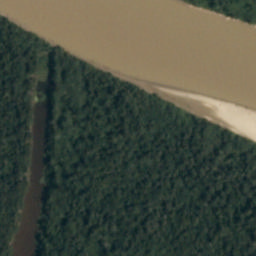

In [30]:
predict(0)

In [31]:
def get_row(idx):
    pred = predictions[idx]
    tags = find_tags(pred, 0.2)
    image_path = learn.data.test_ds.x[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    
    return image_name, tags


In [32]:
get_row(0)


('file_11457', 'primary clear water')

In [33]:
df = pd.DataFrame(columns=['image_name', 'tags'])
for idx in range(len(predictions)):
    if idx % 1000 == 0:
        print(f"Completed: {idx}")
        
    image_name, tags = get_row(idx)
    df.loc[idx] = [image_name, tags]

Completed: 0
Completed: 1000
Completed: 2000
Completed: 3000
Completed: 4000
Completed: 5000
Completed: 6000
Completed: 7000
Completed: 8000
Completed: 9000
Completed: 10000
Completed: 11000
Completed: 12000
Completed: 13000
Completed: 14000
Completed: 15000
Completed: 16000
Completed: 17000
Completed: 18000
Completed: 19000
Completed: 20000
Completed: 21000
Completed: 22000
Completed: 23000
Completed: 24000
Completed: 25000
Completed: 26000
Completed: 27000
Completed: 28000
Completed: 29000
Completed: 30000
Completed: 31000
Completed: 32000
Completed: 33000
Completed: 34000
Completed: 35000
Completed: 36000
Completed: 37000
Completed: 38000
Completed: 39000
Completed: 40000
Completed: 41000
Completed: 42000
Completed: 43000
Completed: 44000
Completed: 45000
Completed: 46000
Completed: 47000
Completed: 48000
Completed: 49000
Completed: 50000
Completed: 51000
Completed: 52000
Completed: 53000
Completed: 54000
Completed: 55000
Completed: 56000
Completed: 57000
Completed: 58000
Completed:

In [35]:
df.head()


,image_name,tags
0,file_11457,primary clear water
1,test_17412,primary clear
2,file_11115,cloudy partly_cloudy
3,test_17884,primary agriculture road partly_cloudy
4,test_34419,clear water cloudy


In [36]:
submission_path = 'submission_sz_256_val_0.2.csv'
df.to_csv(submission_path, index=False)


In [37]:
#kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission_sz_256_val_0.2.csv -m ""

In [38]:
learn.save('stage-exp-1-rn50-191')
torch.save(predictions,'predictions_191.pt')